In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [2]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [3]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [4]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [5]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [6]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [7]:
image_batch.shape

TensorShape([32, 160, 160, 3])

In [8]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [10]:
feature_batch.shape

TensorShape([32, 5, 5, 512])

In [11]:
import numpy as np

image = np.array([[1, 2],
                  [3, 4]])

flattened_image = image.flatten()

print("Original image:\n", image)
print("Original image shape:", image.shape)
print()
print("Flattened image:\n", flattened_image)
print("Flattened image shape:", flattened_image.shape)

Original image:
 [[1 2]
 [3 4]]
Original image shape: (2, 2)

Flattened image:
 [1 2 3 4]
Flattened image shape: (4,)


In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [13]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [14]:
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(32, 2)


In [15]:
base_model.trainable = False

In [16]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 14,978,370
Trainable params: 263,682
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [19]:
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 1s 63ms/step - loss: 0.6889 - accuracy: 0.5328
initial loss: 0.69
initial accuracy: 0.53


In [20]:
EPOCHS = 5   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 83s 142ms/step - loss: 0.2499 - accuracy: 0.9130 - val_loss: 0.1819 - val_accuracy: 0.9256
Epoch 2/5
582/582 [==============================] - 48s 82ms/step - loss: 0.1581 - accuracy: 0.9362 - val_loss: 0.1514 - val_accuracy: 0.9377
Epoch 3/5
582/582 [==============================] - 51s 87ms/step - loss: 0.1450 - accuracy: 0.9402 - val_loss: 0.1487 - val_accuracy: 0.9433
Epoch 4/5
582/582 [==============================] - 51s 87ms/step - loss: 0.1381 - accuracy: 0.9437 - val_loss: 0.1411 - val_accuracy: 0.9445
Epoch 5/5
582/582 [==============================] - 51s 87ms/step - loss: 0.1334 - accuracy: 0.9444 - val_loss: 0.1387 - val_accuracy: 0.9445


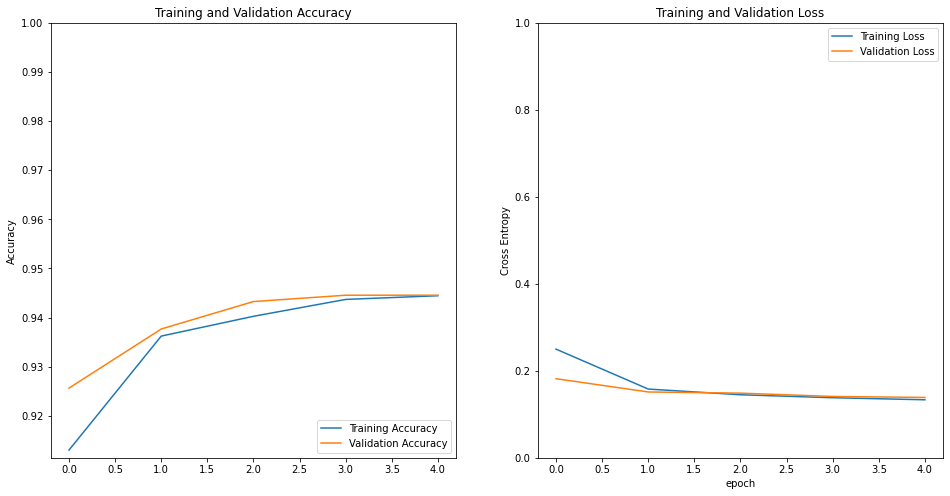

In [21]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[9.9998808e-01, 1.1970496e-05],
       [1.0799337e-01, 8.9200664e-01],
       [3.4480909e-01, 6.5519089e-01],
       [9.9999475e-01, 5.2760502e-06],
       [9.9781680e-01, 2.1832141e-03],
       [9.8808634e-01, 1.1913674e-02],
       [1.3931224e-04, 9.9986064e-01],
       [6.7344546e-01, 3.2655454e-01],
       [9.6236616e-01, 3.7633803e-02],
       [9.6386671e-01, 3.6133282e-02],
       [5.3202475e-05, 9.9994683e-01],
       [9.9994862e-01, 5.1361283e-05],
       [9.8924249e-01, 1.0757476e-02],
       [2.8595048e-06, 9.9999714e-01],
       [9.9807775e-01, 1.9222824e-03],
       [9.8612541e-01, 1.3874637e-02],
       [9.9670452e-01, 3.2955299e-03],
       [3.0906558e-02, 9.6909338e-01],
       [6.5347999e-01, 3.4651995e-01],
       [9.9524790e-01, 4.7521000e-03],
       [9.2571527e-01, 7.4284740e-02],
       [9.8223341e-01, 1.7766597e-02],
       [9.9347162e-01, 6.5283696e-03],
       [9.7836375e-01, 2.1636277e-02],
       [9.9818534e-01, 1.8146988e-03],
       [9.8022318e-01, 1.

In [23]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

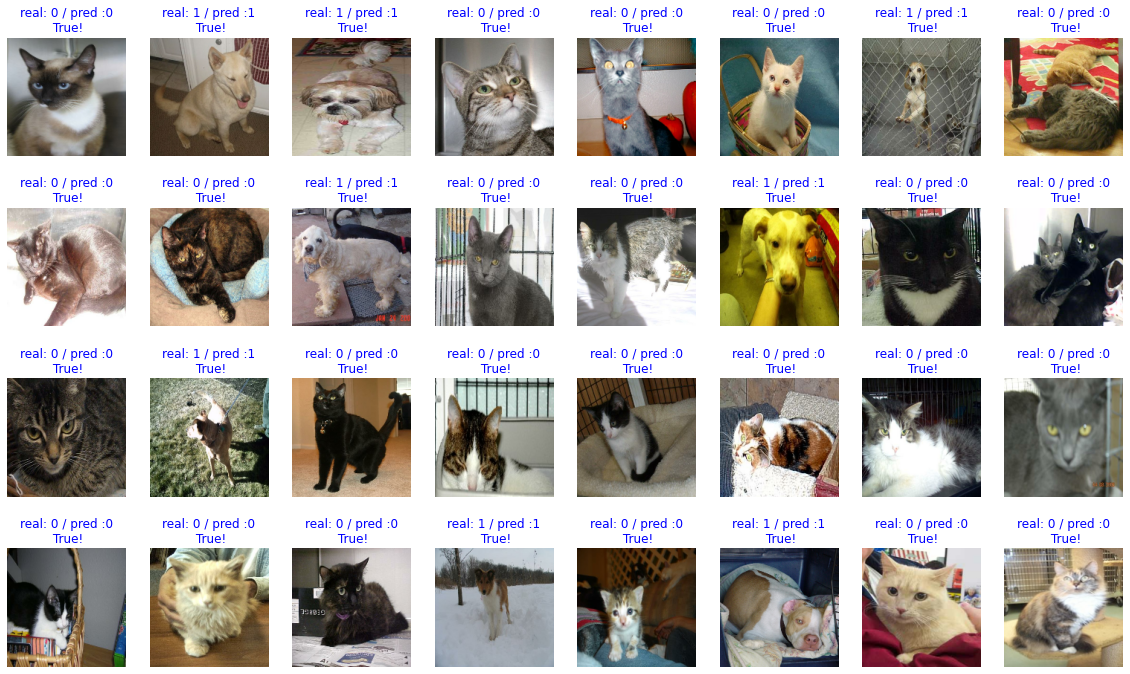

In [24]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [25]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 95% 내외

100.0


In [26]:
import os

checkpoint_dir = os.getcwd() + "/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


In [27]:
img_dir_path = "/home/aiffel0049/aiffel/Exploration/4.classification/images"
if not os.path.exists(img_dir_path):
  os.mkdir(img_dir_path)

In [28]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

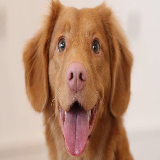

In [29]:
IMG_SIZE = 160
dog_image_path = os.path.join(img_dir_path, 'my_dog.jpeg')

dog_image = load_img(dog_image_path, target_size=(IMG_SIZE, IMG_SIZE))
dog_image

In [30]:
dog_image = img_to_array(dog_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
dog_image.shape

(1, 160, 160, 3)

In [31]:
prediction = model.predict(dog_image)
prediction

array([[0., 1.]], dtype=float32)

In [32]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    image = image/127.5 - 1
    prediction = model.predict(image)[0]
    cat_percentage = round(prediction[0] * 100)
    dog_percentage = round(prediction[1] * 100)
    print(f"This image seems {dog_percentage}% dog, and {cat_percentage}% cat.")

This image seems 100.0% dog, and 0.0% cat.


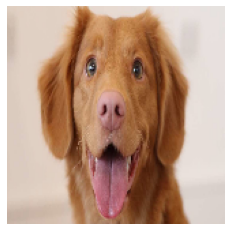

In [33]:
filename = 'my_dog.jpeg'

show_and_predict_image(img_dir_path, filename)

This image seems 100.0% dog, and 0.0% cat.


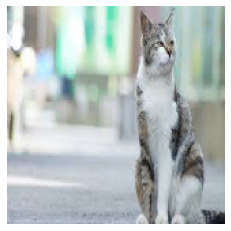

In [34]:
filename = 'my_cat.jpeg'

show_and_predict_image(img_dir_path, filename)

This image seems 100.0% dog, and 0.0% cat.


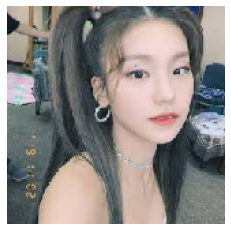

In [35]:
filename = "cat_face.jpg"
show_and_predict_image(img_dir_path, filename)